In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from itertools import chain
from typing import Tuple, List, Optional, Set
from zipfile import ZipFile

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.json import save_json

from ptn.preprocessing.osm import assign_infrastructure_types

## OSM

In [3]:
with ZipFile('../data/raw/spb_osm.json.zip') as zipfile:
    with zipfile.open('spb_osm.json') as file:
        spb_osm = pd.DataFrame(json.load(file)['elements'])
        
spb_osm.head(2)

,type,id,lat,lon,tags,nodes,members
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN
1,node,219779,59.842673,30.320486,NaN,NaN,NaN


In [4]:
spb_osm['type'].value_counts()

node        3156034
way          558869
relation      26820
Name: type, dtype: int64

In [5]:
node_coords = spb_osm.loc[spb_osm['type'] == 'node', ['id', 'lat', 'lon']].set_index('id')

assert node_coords.notna().all().all()

node_coords.head(2)

,lat,lon
id,,
2,59.771793,30.326111
219779,59.842673,30.320486


### Infrastructure objects

In [6]:
mask = spb_osm['tags'].notna()

spb_osm.loc[mask, 'infrastructure_types'] = spb_osm.loc[mask, 'tags'].apply(
    assign_infrastructure_types)

spb_osm['n_infrastructure_types'] = spb_osm['infrastructure_types'].apply(
    lambda l: len(l) if isinstance(l, list) else 0)

spb_osm['n_infrastructure_types'].value_counts()

0    3686308
1      53839
2       1564
3         11
4          1
Name: n_infrastructure_types, dtype: int64

In [7]:
mask = (spb_osm['n_infrastructure_types'] > 0)\
    & (spb_osm['type'] != 'relation')

infrastructure = spb_osm[mask].copy()

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN,[sight_place_tourism],1
492,node,238809,60.189495,29.700196,{'int_name': 'Shoes unknown summer resident (2...,NaN,NaN,[sight_place_tourism],1


In [8]:
def get_name(tags: dict) -> str:
    if not isinstance(tags, dict):
        return
    
    name = tags.get('official_name', tags.get('name:ru', tags.get('name')))
    
    return name


infrastructure['name'] = infrastructure['tags'].apply(get_name)

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,name
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN,[sight_place_tourism],1,Центр Круглого Зала (ЦКЗ)
492,node,238809,60.189495,29.700196,{'int_name': 'Shoes unknown summer resident (2...,NaN,NaN,[sight_place_tourism],1,Башмаки неизвестного дачника (2009)


In [9]:
node_ids = set(node_coords.index.tolist())

mask = infrastructure['nodes'].notna()
n_items = mask.sum()

for i, row in tqdm(infrastructure[mask].iterrows(), total=n_items):
    nodes = list(set(row['nodes']).intersection(node_ids))
    coords = node_coords.loc[nodes].values
    
    distances = get_earth_distances(coords, coords)
    diameter = distances.max()
    
    lat, lon = coords.mean(axis=0)
    
    infrastructure.loc[i, 'lat'] = lat
    infrastructure.loc[i, 'lon'] = lon
    infrastructure.loc[i, 'diameter'] = diameter

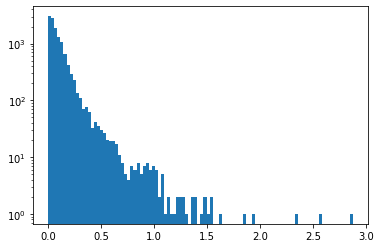

In [10]:
plt.hist(infrastructure['diameter'], bins=100)

plt.yscale('log');

In [15]:
(infrastructure['diameter'] > 0.25).mean()

0.016843888209278252

In [16]:
infrastructure.sort_values(by='diameter', ascending=False).iloc[0]['tags']

{'contact:website': 'http://www.seaport.spb.ru/about/structure/13/',
 'industrial': 'port',
 'landuse': 'industrial',
 'name': 'Первая стивидорная компания',
 'official_name': 'ОАО "Морской порт Санкт-Петербург"',
 'port': 'cargo'}

In [17]:
assert infrastructure[['lat', 'lon']].notna().all().all()

In [18]:
assert infrastructure['id'].nunique() == infrastructure.shape[0]

In [20]:
infrastructure_json = infrastructure\
    .drop(columns=['type', 'tags', 'nodes', 'members', 'n_infrastructure_types', 'diameter'])\
    .rename(columns={'infrastructure_types': 'types'})

infrastructure_json = [row.to_dict() for _, row in infrastructure_json.iterrows()]

In [21]:
len(infrastructure_json)

53135

In [22]:
save_json(infrastructure_json, '../data/infrastructure.json')

<AxesSubplot:>

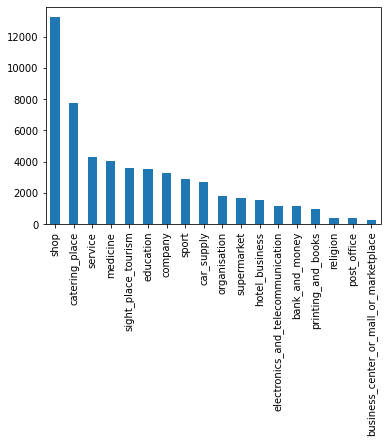

In [26]:
infrastructure_types = pd.Series(chain.from_iterable(infrastructure['infrastructure_types']))

infrastructure_types.value_counts().plot(kind='bar')

### Subway stations

In [ ]:
def is_subway_route(tags: dict) -> bool:
    return isinstance(tags, dict) and tags.get('type') == 'route' and tags.get('route') == 'subway'


df['is_subway_route'] = df['tags'].apply(is_subway_route)

In [ ]:
subway_routes = df[df['is_subway_route']].copy()

subway_routes['name'] = subway_routes['tags'].apply(lambda x: x.get('name'))

subway_routes.head()

In [ ]:
subway_station_ids = {elem['ref'] for _, route in subway_routes.iterrows() for elem in route['members'] if elem['type'] == 'node'}

subway_stations = df[df['id'].isin(subway_station_ids)].copy()

subway_stations

In [ ]:
members = pd.DataFrame(list(chain.from_iterable(subway_routes['members'])))

members[members['ref'].isin(subway_station_ids - set(subway_stations['id']))]

In [ ]:
def is_subway_entrance(tags: dict) -> bool:
    return isinstance(tags, dict) and tags.get('railway') == 'subway_entrance'


df['is_subway_entrance'] = df['tags'].apply(is_subway_entrance)

In [ ]:
def is_subway_station

In [ ]:
mask = (df['type'] == 'node') & (df['is_subway_entrance'])
subway_entrances = df.loc[mask].copy()

subway_entrances['color'] = subway_entrances['tags'].apply(lambda x: x.get('colour'))
subway_entrances['name'] = subway_entrances['tags'].apply(lambda x: x.get('name:ru', x.get('name')))

subway_entrances

In [ ]:
subway_entrances = df.loc[mask].copy()

subway_entrances

In [ ]:
coords = subway_entrances[['lat', 'lon']].values

entrance_distances = get_earth_distances(coords, coords)
entrance_distances[np.arange(entrance_distances.shape[0]), np.arange(entrance_distances.shape[0])] = np.inf

entrance_distances

In [ ]:
argmin = np.argmin(entrance_distances, axis=0)

edges = [
    (subway_entrances['id'].iloc[i], subway_entrances['id'].iloc[j])
    for i, j in enumerate(argmin)
    if entrance_distances[i, j] <= 1
]

In [ ]:
pos = dict(zip(subway_entrances['id'], coords[:, ::-1]))

In [ ]:
g = nx.Graph()
g.add_nodes_from(subway_entrances['id'])
g.add_edges_from(edges)

plt.figure(figsize=(10, 10))
nx.draw(g, pos, node_size=10)

In [ ]:
for c in nx.connected_components(g):
    print(subway_entrances.loc[subway_entrances['id'].isin(c), 'name'], '\n')

In [ ]:
lonlat = df.loc[mask, ['lon', 'lat']].values

plt.figure(figsize=(10, 10))

plt.scatter(*lonlat.T)

In [ ]:
df.loc[mask, 'tags'].tolist()

In [ ]:
df['type'].value_counts()